In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
from skimage import io
from torch.utils.data import (Dataset,DataLoader) 

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_directory = '/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/training-c.csv'
df = pd.read_csv(main_directory, sep=",")
print(df)

         filename           original filename  ...  contributing team  database name
0      c00000.png  Scan_280_digit_6_num_7.png  ...   Buet_Backpropers     training-c
1      c00001.png   Scan_29_digit_1_num_1.png  ...   Buet_Backpropers     training-c
2      c00002.png  Scan_131_digit_3_num_1.png  ...   Buet_Backpropers     training-c
3      c00003.png  Scan_160_digit_2_num_2.png  ...   Buet_Backpropers     training-c
4      c00004.png  Scan_202_digit_7_num_0.png  ...   Buet_Backpropers     training-c
...           ...                         ...  ...                ...            ...
24293  c24293.png  Scan_167_digit_3_num_4.png  ...   Buet_Backpropers     training-c
24294  c24294.png  Scan_174_digit_2_num_8.png  ...   Buet_Backpropers     training-c
24295  c24295.png  Scan_152_digit_7_num_4.png  ...   Buet_Backpropers     training-c
24296  c24296.png  Scan_123_digit_2_num_2.png  ...   Buet_Backpropers     training-c
24297  c24297.png    Scan_2_digit_7_num_6.png  ...   Buet_Backpro

In [ ]:
df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [ ]:
df = df.drop(['original filename','scanid','database name original', 'contributing team','database name'], axis = 1)

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/modified.csv',index = False)

In [ ]:
batch_size = 15
input_dim = 100*100 
output_dim = 10
learning_rate = 0.001 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class HandWrittenNumberRecognition(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
transform_Img = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(100),
                                    transforms.ToTensor()])

In [ ]:
dataset = HandWrittenNumberRecognition(
    csv_file="/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/modified.csv",
    root_dir="/content/drive/MyDrive/Root/training-c",
    transform=transform_Img
)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19438,4860])
print(len(train_dataset))
print(len(test_dataset))

19438
4860


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
      
        self.linear_1 = nn.Linear(input_size,350)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(350, 300)
        self.tanh_2   = nn.Tanh()

        self.linear_3 = nn.Linear(300, 250)
        self.tanh_3 =  nn.Tanh()

        self.linear_4 = nn.Linear(250, 200)
        self.tanh_4   =  nn.Tanh()

        self.linear_5 = nn.Linear(200, 150)
        self.tanh_5 =  nn.Tanh()

        self.linear_6 = nn.Linear(150, 100)
        self.tanh_6 =  nn.Tanh()

        self.linear_out = nn.Linear(100,num_classes)

    def forward(self, x):
       
        out  = self.linear_1(x)
        out =  self.tanh_1(out)
        
        out  = self.linear_2(out)
        out =  self.tanh_2(out)

        out  = self.linear_3(out)
        out =  self.tanh_3(out)

        out  = self.linear_4(out)
        out =  self.tanh_4(out)

        out  = self.linear_5(out)
        out =  self.tanh_5(out)

        out  = self.linear_6(out)
        out =  self.tanh_6(out)
        
        probas  = self.linear_out(out)
        return probas



model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.7)

In [ ]:
iter = 0
total_loss = []
iteration = []
correctly_classified_PerEpoch = []
accuracy_perEpoch = []
num_of_epoch = []
for epoch in range(25):
    print('Epoch: ',epoch+1)
    num_of_epoch.append(epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 100*100).to(device)

        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        print('Iteration no: ',iter)
        if iter % 1500 == 0:
            print('loss in iteration ',iter,'= ',loss.item())
            total_loss.append(loss.item())
            iteration.append(iter)

    correct = 0
    total = 0
    for images, labels in test_loader:
          
          images = images.view(-1,100*100).to(device)
          outputs = model(images)
 
          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)
 
          if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
                correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    accuracy_perEpoch.append(accuracy)
    correctly_classified_PerEpoch.append(correct.item())
    print('Total Data: {}.  CorrectlyPredicted: {}.'.format(total,correct))
    print('Accuracy in epoch ',epoch+1,'=',accuracy)

Streaming output truncated to the last 5000 lines.
Iteration no:  27415
Iteration no:  27416
Iteration no:  27417
Iteration no:  27418
Iteration no:  27419
Iteration no:  27420
Iteration no:  27421
Iteration no:  27422
Iteration no:  27423
Iteration no:  27424
Iteration no:  27425
Iteration no:  27426
Iteration no:  27427
Iteration no:  27428
Iteration no:  27429
Iteration no:  27430
Iteration no:  27431
Iteration no:  27432
Iteration no:  27433
Iteration no:  27434
Iteration no:  27435
Iteration no:  27436
Iteration no:  27437
Iteration no:  27438
Iteration no:  27439
Iteration no:  27440
Iteration no:  27441
Iteration no:  27442
Iteration no:  27443
Iteration no:  27444
Iteration no:  27445
Iteration no:  27446
Iteration no:  27447
Iteration no:  27448
Iteration no:  27449
Iteration no:  27450
Iteration no:  27451
Iteration no:  27452
Iteration no:  27453
Iteration no:  27454
Iteration no:  27455
Iteration no:  27456
Iteration no:  27457
Iteration no:  27458
Iteration no:  27459
Iter

In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/Experiment_02_06/ALLCOVERED'
save_model = True
 
if save_model is True:
    torch.save(model.state_dict(), root_path + '170104027_Exp2_6.pkl') 

In [ ]:
print('loss count after every 750 iteration: ',total_loss)
print('iteration count: ',iteration)
print('Correctly classfied per epoch: ',correctly_classified_PerEpoch)
print('accuracy per epoch: ',accuracy_perEpoch)
print('Epoch list: ',num_of_epoch)

loss count after every 750 iteration:  [2.2971456050872803, 2.3194172382354736, 2.3025319576263428, 2.31793475151062, 2.308027982711792, 2.3021693229675293, 2.281933307647705, 2.3082330226898193, 2.288632869720459, 2.298614501953125, 2.262160301208496, 2.202255964279175, 2.2109243869781494, 2.0634450912475586, 2.0069801807403564, 2.11981463432312, 2.3542861938476562, 2.211238145828247, 2.2824244499206543, 2.2781670093536377, 2.0570878982543945]
iteration count:  [1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, 13500, 15000, 16500, 18000, 19500, 21000, 22500, 24000, 25500, 27000, 28500, 30000, 31500]
Correctly classfied per epoch:  [466, 485, 567, 512, 530, 471, 470, 610, 731, 746, 730, 488, 454, 565, 700, 960, 1193, 1001, 903, 1166, 967, 1157, 1007, 1227, 1422]
accuracy per epoch:  [9.588477366255145, 9.979423868312757, 11.666666666666666, 10.534979423868313, 10.905349794238683, 9.691358024691358, 9.670781893004115, 12.551440329218106, 15.041152263374485, 15.349794238683128, 15.02057

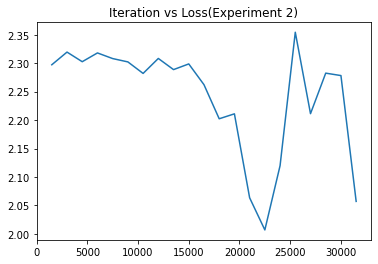

In [ ]:
plt.plot(iteration,total_loss)
plt.title('Iteration vs Loss(Experiment 2)')
plt.show()

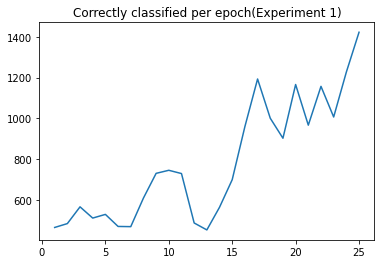

In [ ]:
plt.plot(num_of_epoch,correctly_classified_PerEpoch)
plt.title('Correctly classified per epoch(Experiment 1)')
plt.show()

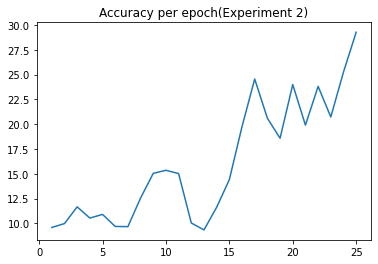

In [ ]:
plt.plot(num_of_epoch,accuracy_perEpoch)
plt.title('Accuracy per epoch(Experiment 2)')
plt.show()